<a href="https://colab.research.google.com/github/XhrisGG/challenge_TelecomX_Parte2/blob/main/TelecomX_2_integrado_CGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/angelesGladin/TelecomX_2/blob/main/TelecomX_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#** TELECOM X - PARTE 2: PREDICCIÓN DE CANCELACIÓN (Churn)**

---
Tu nueva misión es desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación, y te corresponde a ti construir un pipeline robusto para esta etapa inicial de modelado.


##📊 EXTRACCIÓN DE LOS DATOS

In [1]:
import pandas as  pd
import warnings
warnings.filterwarnings('ignore')

url_datos = 'https://raw.githubusercontent.com/XhrisGG/challenge_TelecomX_Parte2/e68ff2ccc48eec954f63988b8df094b4015eea1b/datos_tratados.csv'

datos = pd.read_csv(url_datos)
datos

,id_cliente,abandono,genero,es_ciudadano_senior,tiene_pareja,tiene_dependientes,meses_en_empresa,servicio_telefonico,lineas_multiples,tipo_internet,...,proteccion_dispositivo,soporte_tecnico,tv_streaming,peliculas_streaming,tipo_contrato,factura_electronica,metodo_pago,cargos_mensuales,cargos_totales,cuentas_diarias
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,one year,1,mailed check,65.60,593.30,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,month to month,0,mailed check,59.90,542.40,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,month to month,1,electronic check,73.90,280.85,2.463333
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,month to month,1,electronic check,98.00,1237.85,3.266667
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,month to month,1,mailed check,83.90,267.40,2.796667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7251,9987-LUTYD,0,Female,0,0,0,13,1,No,DSL,...,No,Yes,No,No,one year,0,mailed check,55.15,742.90,1.838333
7252,9992-RRAMN,1,Male,0,1,0,22,1,Yes,Fiber optic,...,No,No,No,Yes,month to month,1,electronic check,85.10,1873.70,2.836667
7253,9992-UJOEL,0,Male,0,0,0,2,1,No,DSL,...,No,No,No,No,month to month,1,mailed check,50.30,92.75,1.676667
7254,9993-LHIEB,0,Male,0,1,1,67,1,No,DSL,...,Yes,Yes,No,Yes,two year,0,mailed check,67.85,4627.65,2.261667


### 🛠️ Preparación de los Datos Y Análisis exploratorio

>En la etapa de eliminación de columnas irrelevantes, el objetivo es excluir variables que:

>No tienen valor predictivo (ej.: identificadores únicos).
Son redundantes con otras.
>Pueden causar fuga de datos (data leakage).

>**Nota de integración**: EDA, preprocesamiento y modelado añadidos sin alterar la estructura.

In [2]:

# === Setup adicional (integrado, ligero) ===
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, fbeta_score)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

RANDOM_STATE = 42
CSV_PATH = 'https://raw.githubusercontent.com/XhrisGG/challenge_TelecomX_Parte2/e68ff2ccc48eec954f63988b8df094b4015eea1b/datos_tratados.csv'
try:
    df
except NameError:
    df = pd.read_csv(CSV_PATH)
candidate_targets = [c for c in df.columns if c.lower() in ['churn','churn_flag','target','is_churn','default','abandono','label','y']]
target = candidate_targets[0] if candidate_targets else None
assert target is not None, "Define la variable objetivo en 'target'."


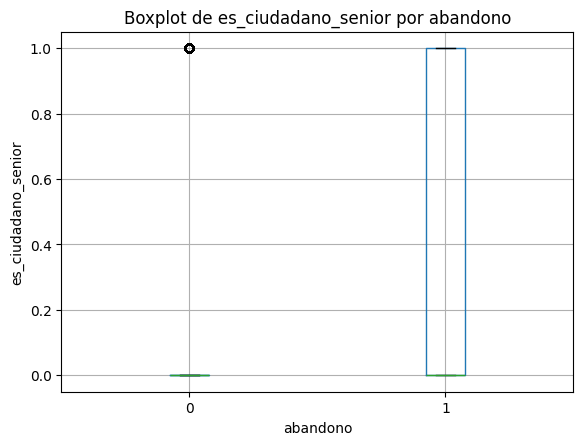

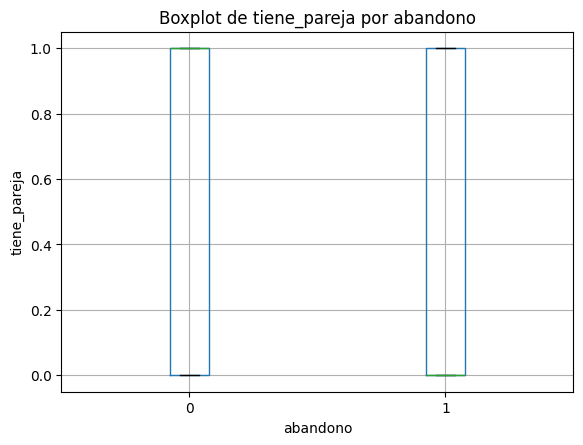

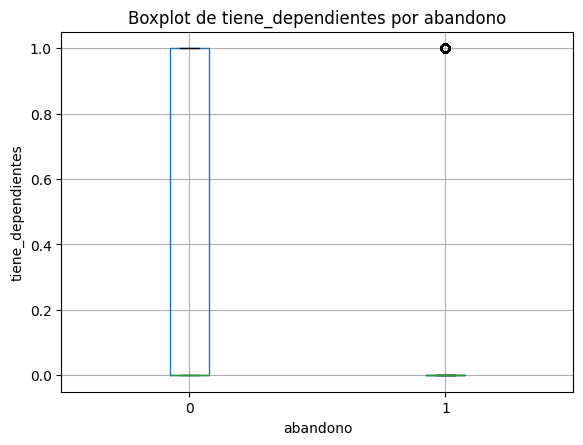

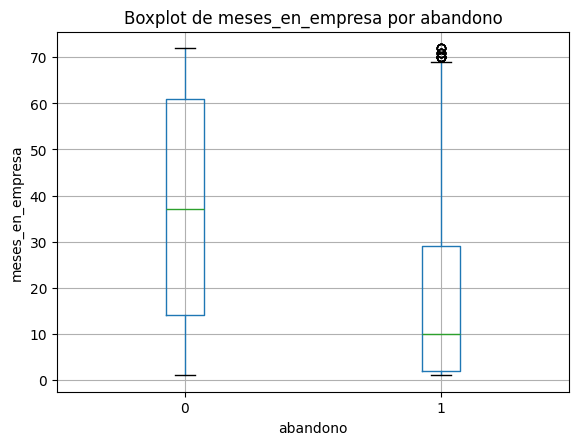

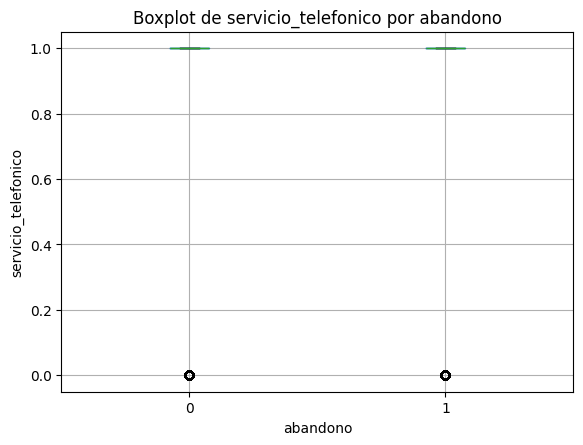

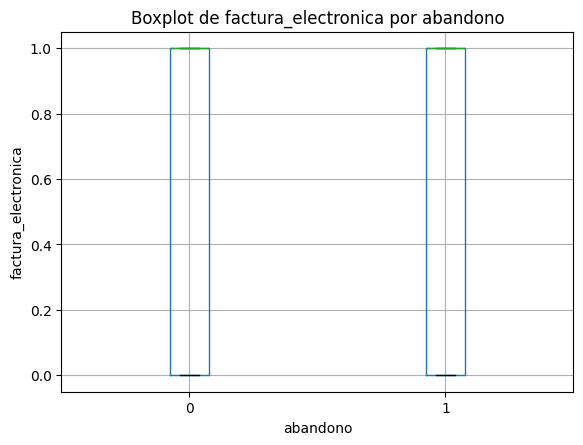

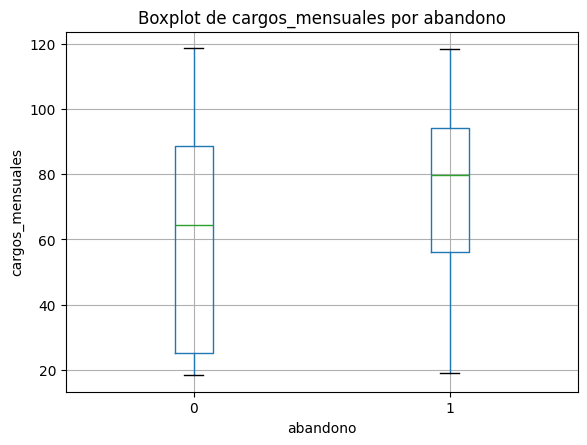

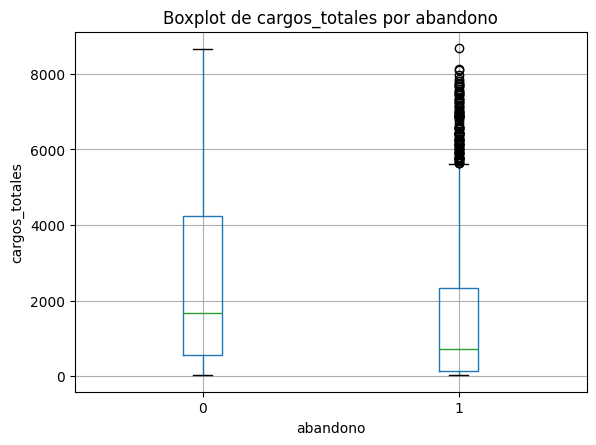

In [3]:
# === Boxplots recomendados (integrado) ===
X = df.drop(columns=[target]); y = df[target]
if y.dtype == 'object':
    mapping = {k:(0 if i==0 else 1) for i,k in enumerate(y.value_counts().index)}
    y = y.map(mapping)
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

cols = num_cols[:8]
for col in cols:
    df[[col, target]].boxplot(by=target)
    plt.title(f"Boxplot de {col} por {target}")
    plt.suptitle("")
    plt.xlabel(target); plt.ylabel(col)
    plt.show()


In [4]:
print("Shape:", datos.shape)
print("\nTipos de datos:")
print(datos.info())
print("\nEstadísticas Variables númericas:")
display(datos.describe())
print("\nEstadísticas variables categóricas:")
display(datos.describe(include='O'))

Shape: (7256, 22)

Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7256 entries, 0 to 7255
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_cliente              7256 non-null   object 
 1   abandono                7256 non-null   int64  
 2   genero                  7256 non-null   object 
 3   es_ciudadano_senior     7256 non-null   int64  
 4   tiene_pareja            7256 non-null   int64  
 5   tiene_dependientes      7256 non-null   int64  
 6   meses_en_empresa        7256 non-null   int64  
 7   servicio_telefonico     7256 non-null   int64  
 8   lineas_multiples        7256 non-null   object 
 9   tipo_internet           7256 non-null   object 
 10  seguridad_online        7256 non-null   object 
 11  respaldo_online         7256 non-null   object 
 12  proteccion_dispositivo  7256 non-null   object 
 13  soporte_tecnico         7256 non-null   object 
 14  tv_st

,abandono,es_ciudadano_senior,tiene_pareja,tiene_dependientes,meses_en_empresa,servicio_telefonico,factura_electronica,cargos_mensuales,cargos_totales,cuentas_diarias
count,7256.000000,7256.0000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000
mean,0.257580,0.1629,0.483600,0.299063,32.395535,0.902839,0.593716,64.755423,2280.634213,2.158514
std,0.437332,0.3693,0.499765,0.457879,24.558067,0.296197,0.491173,30.125739,2268.632997,1.004191
min,0.000000,0.0000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.608333
25%,0.000000,0.0000,0.000000,0.000000,9.000000,1.000000,0.000000,35.450000,400.225000,1.181667
50%,0.000000,0.0000,0.000000,0.000000,29.000000,1.000000,1.000000,70.300000,1391.000000,2.343333
75%,1.000000,0.0000,1.000000,1.000000,55.000000,1.000000,1.000000,89.900000,3785.300000,2.996667
max,1.000000,1.0000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,3.958333



Estadísticas variables categóricas:


,id_cliente,genero,lineas_multiples,tipo_internet,seguridad_online,respaldo_online,proteccion_dispositivo,soporte_tecnico,tv_streaming,peliculas_streaming,tipo_contrato,metodo_pago
count,7256,7256,7256,7256,7256,7256,7256,7256,7256,7256,7256,7256
unique,7256,2,3,3,3,3,3,3,3,3,3,4
top,9995-HOTOH,Male,No,Fiber optic,No,No,No,No,No,No,month to month,electronic check
freq,1,3669,3490,3198,3607,3181,3194,3581,2895,2866,4005,2445


**OBSERVACINES:**



---



+ Existe un desbalance en la variable de respuesta (abandono), por lo que se usaran ajuste de pesos en los modelos.

+ Se observa una posible relación entre tipo de contrato y abandono, que puede ser clave en el modelado.

+ Las variables categóricas como tipo_internet, metodo_pago y los servicios contratados ofrecen información valiosa para identificar patrones de cancelación.

+ Será eliminada la variable id_cliente y luego proceder con la codificación de variables categóricas para continuar con el análisis correlacional y la construcción del modelo.


###Distribución de la variable de respuesta (abandono)

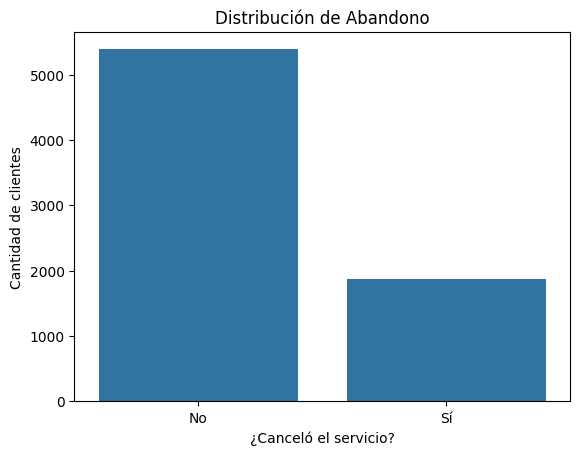

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.countplot(data=datos, x='abandono')
plt.title('Distribución de Abandono')
plt.xlabel('¿Canceló el servicio?')
plt.ylabel('Cantidad de clientes')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

**OBSERVACIONES**


---



+ Se visualiza un aparente desbalance de clases: la mayoría de los clientes no han cancelado. Esto puede influir en los modelos, por lo que será necesario realizar un balence en nuestros datos.

###Histograma de variables númericas

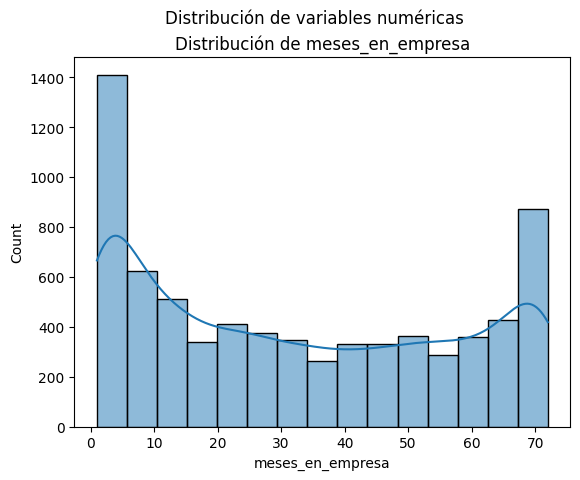

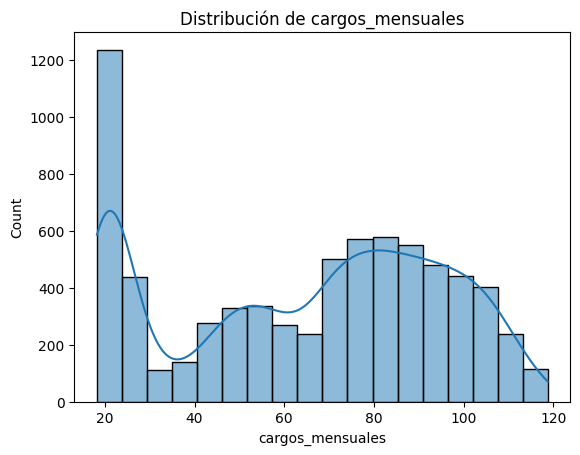

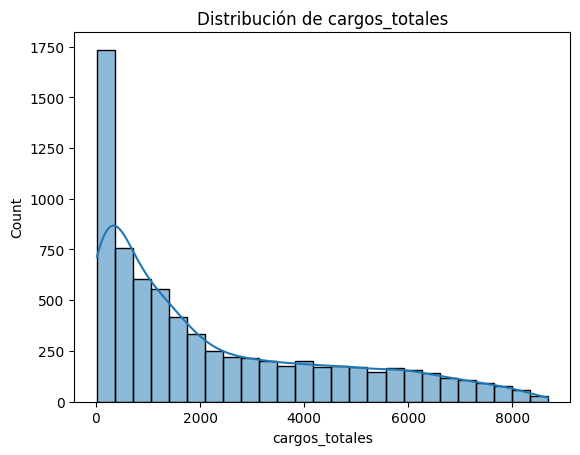

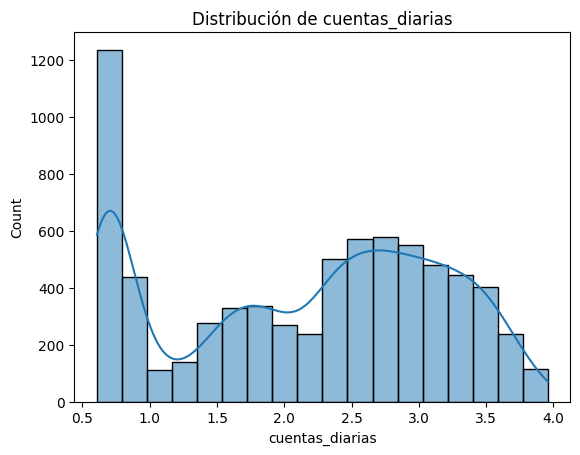

In [6]:
##recreando la formula diacoins

def ancho_bin(df,columna):
  q75,q25 = np.percentile(df[columna],[75,25])
  iqr = q75-q25
  ancho = 2*iqr*np.power(len(df[columna]), -1/3)
  return ancho

numericas = ['meses_en_empresa', 'cargos_mensuales', 'cargos_totales', 'cuentas_diarias']
plt.suptitle('Distribución de variables numéricas')

for col in numericas:
  binwidth = ancho_bin(datos, col)
  sns.histplot(data=datos,x=col,kde=True, binwidth=binwidth)
  plt.title(f'Distribución de {col}')
  plt.show()

**OBSERVACIONES**



---



+ meses_en_empresa: mayor densidad en clientes recientes (pico en los primeros meses).

+ cargos_totales: distribución sesgada a la derecha, algunos clientes acumulan muchos cargos.

+ cuentas_diarias y cuentas_mensuales: parece tener un rango limitado, útil para normalizar después, a demás ambos gráficos muestra una gran similitud por lo que puede sesgar el modelo.

###Boxplots: Variables numéricas vs Abandono

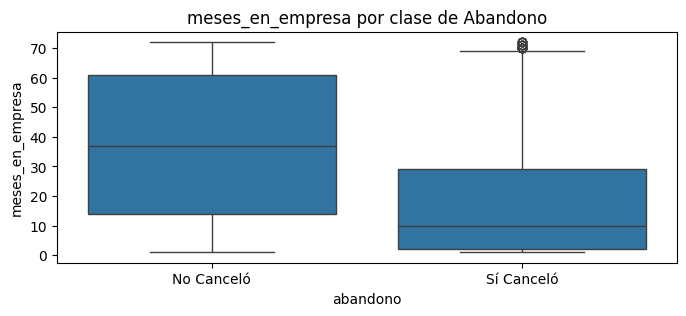

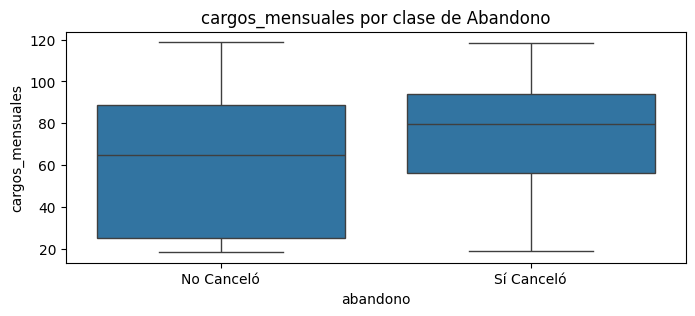

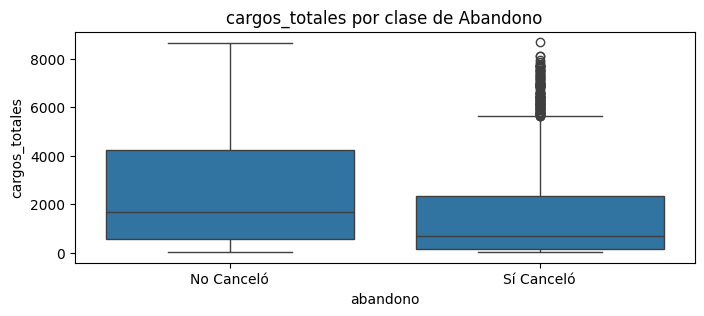

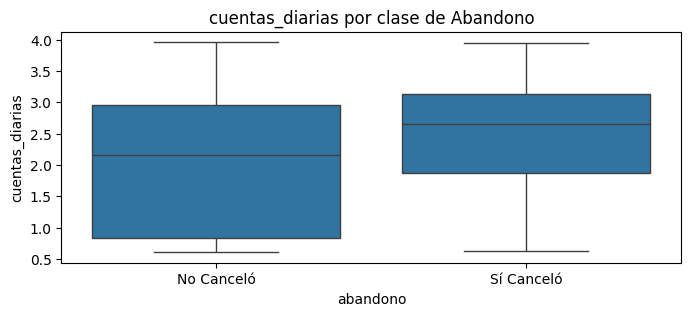

In [7]:
for col in numericas:
    plt.figure(figsize=(8, 3))
    sns.boxplot(data=datos, x='abandono', y=col)
    plt.title(f'{col} por clase de Abandono')
    plt.xticks([0, 1], ['No Canceló', 'Sí Canceló'])
    plt.show()

**OBSERVACIONES**


---


+ Clientes que cancelan tienen significativamente menos tiempo en la empresa.

+ cargos_totales y meses_en_empresa están ligados a la permanencia, por lo tanto son importantes para detectar abandono.

+ meses_en_empresa, cargos_mensuales y cargos_totales tienen mayor importancia y deben ser normalizadas.

###Gráficos de barras: Categóricas vs Abandono

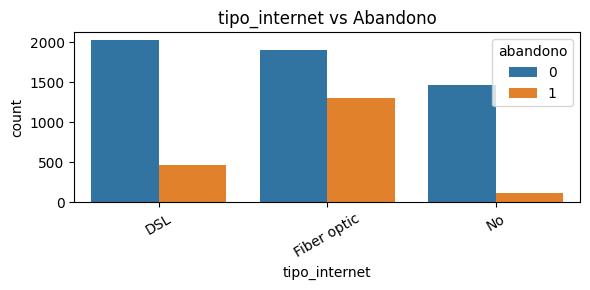

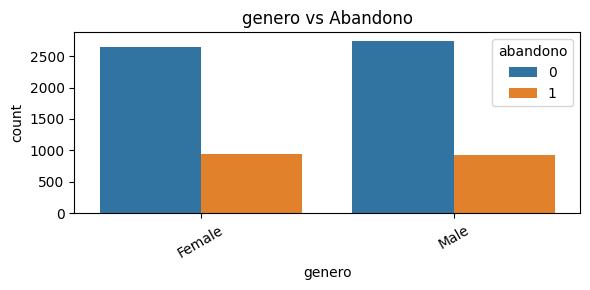

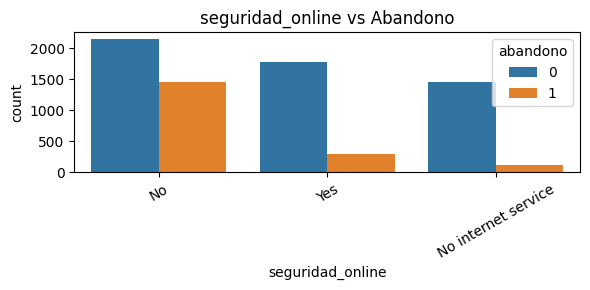

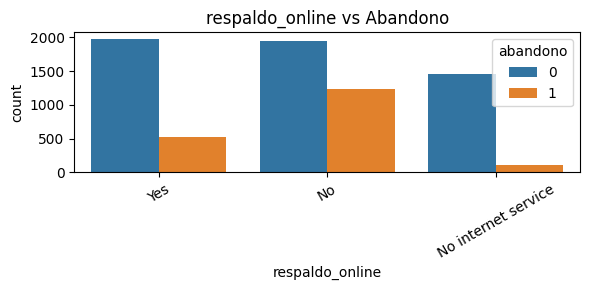

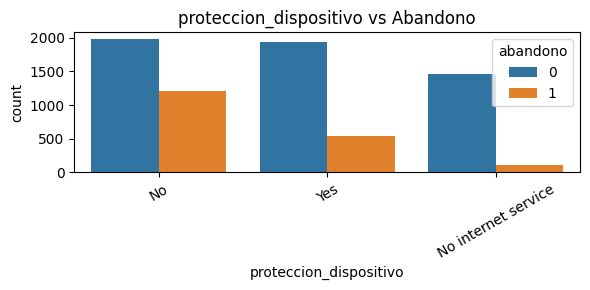

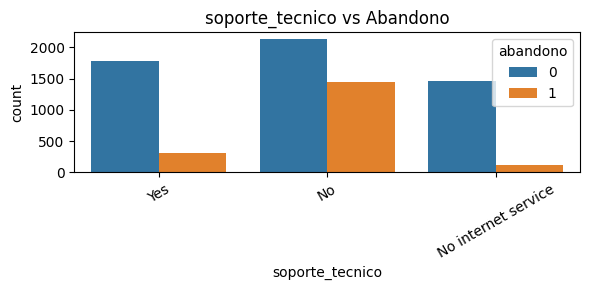

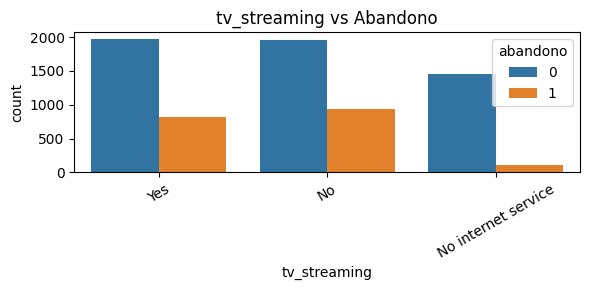

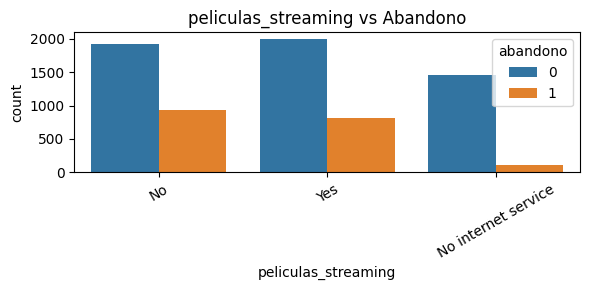

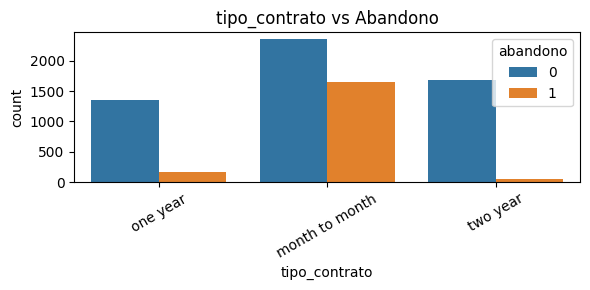

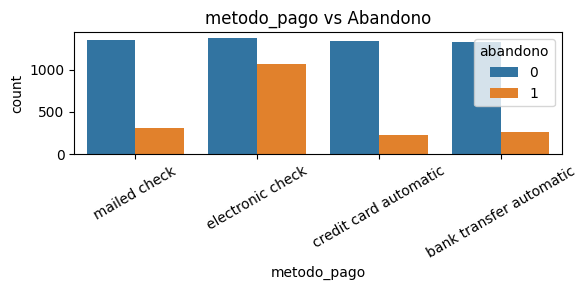

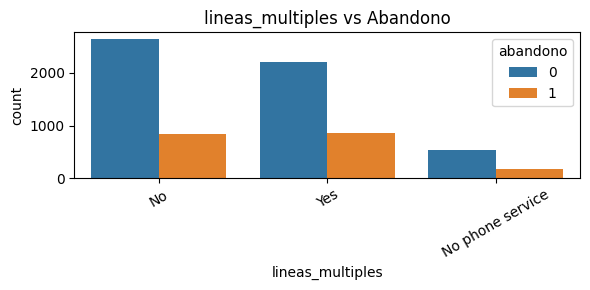

In [8]:
categoricas = ['tipo_internet','genero', 'seguridad_online', 'respaldo_online',
               'proteccion_dispositivo', 'soporte_tecnico', 'tv_streaming',
               'peliculas_streaming', 'tipo_contrato', 'metodo_pago',
               'lineas_multiples']
for col in categoricas:
    plt.figure(figsize=(6,3))
    sns.countplot(data=datos, x=col, hue='abandono')
    plt.title(f'{col} vs Abandono')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

**OBSERVACIONES**



---



+ Variables altamente correlacionadas con abandono:

tipo_contrato:
Los clientes con contrato "month to month" tienen una tasa de abandono notablemente mayor.

metodo_pago:
"Electronic check" tiene mayor abandono que pagos automáticos.

soporte_tecnico, tv_streaming, seguridad_online:
Clientes que no tienen estos servicios tienden más al abandono.



---



+ Variables con poca influencia visual:

genero:
 No hay diferencia significativa entre hombres y mujeres.

es_ciudadano_senior:
 Ligera diferencia, pero no muy marcada.

tiene_dependientes y tiene_pareja:
Patrones no evidentes.

servicio_telefonico:
Casi todos tienen, no aporta variabilidad.


##🛠️ PREPARACIÓN DE LOS DATOS

In [9]:
# === Preprocesamiento + Modelos (integrado) ===
X = df.drop(columns=[target]); y = df[target]
if y.dtype == 'object':
    mapping = {k:(0 if i==0 else 1) for i,k in enumerate(y.value_counts().index)}
    y = y.map(mapping)
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler(with_mean=False))]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if y.nunique()>1 else None
)

lr = Pipeline([("prep", preprocessor), ("clf", LogisticRegression(max_iter=1500, class_weight="balanced"))])
rf = Pipeline([("prep", preprocessor), ("clf", RandomForestClassifier(n_estimators=150, n_jobs=-1, class_weight="balanced_subsample", random_state=RANDOM_STATE))])
dt = Pipeline([("prep", preprocessor), ("clf", DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, class_weight="balanced", random_state=RANDOM_STATE))])

lr.fit(X_train, y_train); rf.fit(X_train, y_train); dt.fit(X_train, y_train)

def pr_auc(y_true, scores):
    p, r, _ = precision_recall_curve(y_true, scores)
    return auc(r, p)

y_prob_lr = lr.predict_proba(X_test)[:,1]; y_prob_rf = rf.predict_proba(X_test)[:,1]; y_prob_dt = dt.predict_proba(X_test)[:,1]
auc_lr = roc_auc_score(y_test, y_prob_lr); pra_lr = pr_auc(y_test, y_prob_lr)
auc_rf = roc_auc_score(y_test, y_prob_rf); pra_rf = pr_auc(y_test, y_prob_rf)
auc_dt = roc_auc_score(y_test, y_prob_dt); pra_dt = pr_auc(y_test, y_prob_dt)

print("AUC ROC ->  LR:", round(auc_lr,3), "| RF:", round(auc_rf,3), "| DT:", round(auc_dt,3))
print("PR  AUC ->  LR:", round(pra_lr,3), "| RF:", round(pra_rf,3), "| DT:", round(pra_dt,3))
for name, probs in [("LR", y_prob_lr), ("RF", y_prob_rf), ("DT", y_prob_dt)]:
    print("\nReporte @0.5 -", name)
    print(classification_report(y_test, (probs>=0.5).astype(int)))

AUC ROC ->  LR: 0.838 | RF: 0.823 | DT: 0.827
PR  AUC ->  LR: 0.618 | RF: 0.587 | DT: 0.589

Reporte @0.5 - LR
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1078
           1       0.53      0.77      0.63       374

    accuracy                           0.77      1452
   macro avg       0.72      0.77      0.73      1452
weighted avg       0.81      0.77      0.78      1452


Reporte @0.5 - RF
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1078
           1       0.61      0.49      0.54       374

    accuracy                           0.79      1452
   macro avg       0.72      0.69      0.70      1452
weighted avg       0.78      0.79      0.78      1452


Reporte @0.5 - DT
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1078
           1       0.49      0.81      0.61       374

    accuracy                     

In [10]:

# === Ajuste de umbral F2 (integrado) ===
def best_threshold(y_true, y_scores, beta=2.0):
    p, r, th = precision_recall_curve(y_true, y_scores)
    scores = [fbeta_score(y_true, (y_scores >= t).astype(int), beta=beta) for t in th]
    idx = int(np.argmax(scores))
    return float(th[idx]), float(scores[idx])

for name, probs in [("LR", y_prob_lr), ("RF", y_prob_rf), ("DT", y_prob_dt)]:
    thr, f2 = best_threshold(y_test, probs, beta=2.0)
    print(f"{name} -> thr* (F2):", round(thr,3), " | F2:", round(f2,3))
    print("Reporte @thr*")
    print(classification_report(y_test, (probs>=thr).astype(int)))


LR -> thr* (F2): 0.274  | F2: 0.748
Reporte @thr*
              precision    recall  f1-score   support

           0       0.95      0.57      0.72      1078
           1       0.43      0.92      0.58       374

    accuracy                           0.66      1452
   macro avg       0.69      0.75      0.65      1452
weighted avg       0.82      0.66      0.68      1452

RF -> thr* (F2): 0.153  | F2: 0.739
Reporte @thr*
              precision    recall  f1-score   support

           0       0.94      0.59      0.72      1078
           1       0.43      0.90      0.58       374

    accuracy                           0.67      1452
   macro avg       0.69      0.74      0.65      1452
weighted avg       0.81      0.67      0.69      1452

DT -> thr* (F2): 0.342  | F2: 0.736
Reporte @thr*
              precision    recall  f1-score   support

           0       0.94      0.63      0.75      1078
           1       0.45      0.88      0.59       374

    accuracy                    

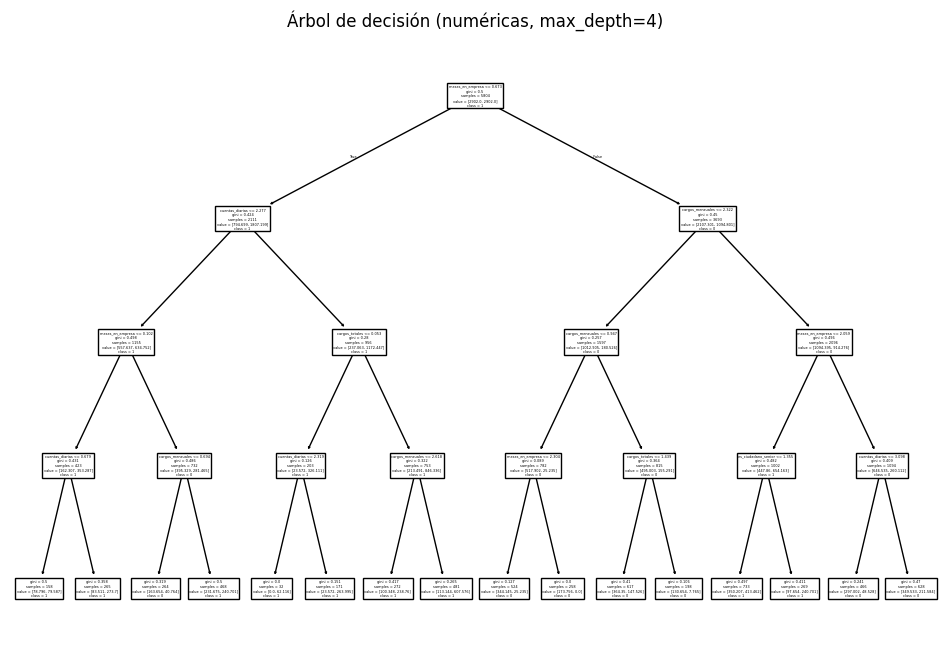

In [11]:

# === Árbol interpretable (numéricas) (integrado) ===
simple_num_pipe = make_pipeline(SimpleImputer(strategy="median"),
                                StandardScaler(with_mean=False),
                                DecisionTreeClassifier(max_depth=4, class_weight="balanced", random_state=RANDOM_STATE))
num_cols = [c for c in df.columns if c != target and df[c].dtype != 'object']
simple_num_pipe.fit(X_train[num_cols], y_train)
from sklearn.tree import plot_tree
plt.figure(figsize=(12,8))
plot_tree(simple_num_pipe.named_steps['decisiontreeclassifier'],
          feature_names=num_cols, class_names=["0","1"], filled=False)
plt.title("Árbol de decisión (numéricas, max_depth=4)"); plt.show()


###Eliminación de Columnas con identificador único

In [12]:
datos = datos.drop('id_cliente', axis=1)
datos.sample(2)

,abandono,genero,es_ciudadano_senior,tiene_pareja,tiene_dependientes,meses_en_empresa,servicio_telefonico,lineas_multiples,tipo_internet,seguridad_online,...,proteccion_dispositivo,soporte_tecnico,tv_streaming,peliculas_streaming,tipo_contrato,factura_electronica,metodo_pago,cargos_mensuales,cargos_totales,cuentas_diarias
2743,1,Male,0,1,1,1,1,No,Fiber optic,No,...,No,No,Yes,Yes,month to month,0,mailed check,89.15,89.15,2.971667
88,1,Female,0,0,0,1,1,Yes,Fiber optic,No,...,No,No,No,No,month to month,1,mailed check,80.20,80.20,2.673333


###Codificación de las variables

In [13]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7256 entries, 0 to 7255
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   abandono                7256 non-null   int64  
 1   genero                  7256 non-null   object 
 2   es_ciudadano_senior     7256 non-null   int64  
 3   tiene_pareja            7256 non-null   int64  
 4   tiene_dependientes      7256 non-null   int64  
 5   meses_en_empresa        7256 non-null   int64  
 6   servicio_telefonico     7256 non-null   int64  
 7   lineas_multiples        7256 non-null   object 
 8   tipo_internet           7256 non-null   object 
 9   seguridad_online        7256 non-null   object 
 10  respaldo_online         7256 non-null   object 
 11  proteccion_dispositivo  7256 non-null   object 
 12  soporte_tecnico         7256 non-null   object 
 13  tv_streaming            7256 non-null   object 
 14  peliculas_streaming     7256 non-null   

**OBSERVACIONES**


---


Se observan variables que tienen cadenas de string (object) por lo que se debe modificar para que sea compatibles con nuestros modelos de ML.

In [14]:
#codificación de las variables categóricas
datos_codi = pd.get_dummies(data=datos,columns=categoricas, dtype=int)
datos_codi.sample(2)

,abandono,es_ciudadano_senior,tiene_pareja,tiene_dependientes,meses_en_empresa,servicio_telefonico,factura_electronica,cargos_mensuales,cargos_totales,cuentas_diarias,...,tipo_contrato_month to month,tipo_contrato_one year,tipo_contrato_two year,metodo_pago_bank transfer automatic,metodo_pago_credit card automatic,metodo_pago_electronic check,metodo_pago_mailed check,lineas_multiples_No,lineas_multiples_No phone service,lineas_multiples_Yes
1852,0,0,1,0,3,1,1,46.10,130.15,1.536667,...,1,0,0,0,0,0,1,1,0,0
6837,0,0,1,0,50,1,1,19.85,943.10,0.661667,...,0,1,0,1,0,0,0,1,0,0


**OBSERVACIONES**


---



Utilizamos un método de pandas que nos permite codificar nuestras variables con ceros y unos de forma numérica: get_dummies. Usaremos pd.get_dummies y especificaremos nuestro conjunto de datos, las columnas que queremos codificar (columns=categóricas) y el tipo de dato (dtype) que será entero.

###Validación de la codificación de los datos

In [15]:
datos_codi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7256 entries, 0 to 7255
Data columns (total 43 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   abandono                                    7256 non-null   int64  
 1   es_ciudadano_senior                         7256 non-null   int64  
 2   tiene_pareja                                7256 non-null   int64  
 3   tiene_dependientes                          7256 non-null   int64  
 4   meses_en_empresa                            7256 non-null   int64  
 5   servicio_telefonico                         7256 non-null   int64  
 6   factura_electronica                         7256 non-null   int64  
 7   cargos_mensuales                            7256 non-null   float64
 8   cargos_totales                              7256 non-null   float64
 9   cuentas_diarias                             7256 non-null   float64
 10  tipo_interne

**OBSERVACIONES**


---


En esta validación podemos observar que los datos que se encontraban con cadena de string (object) han cambiado a formato de entero (int), también se logra observar que ha crecido el número de columnas obtenidas.

## 📝 ANÁLISIS DE CORRELACIONES GLOBAL (como referencia)

In [16]:
correlation = datos_codi.corr()['abandono'].sort_values(ascending=False)
print(correlation)

abandono                                      1.000000
tipo_contrato_month to month                  0.395067
seguridad_online_No                           0.335271
soporte_tecnico_No                            0.330060
tipo_internet_Fiber optic                     0.300416
metodo_pago_electronic check                  0.294181
respaldo_online_No                            0.262721
proteccion_dispositivo_No                     0.246512
cuentas_diarias                               0.189393
cargos_mensuales                              0.189393
factura_electronica                           0.186309
es_ciudadano_senior                           0.146400
peliculas_streaming_No                        0.128793
tv_streaming_No                               0.126338
tv_streaming_Yes                              0.062456
peliculas_streaming_Yes                       0.060092
lineas_multiples_Yes                          0.039277
servicio_telefonico                           0.012337
genero_Fem

**OBSERVACIONES**

Este análisis servirá como una referencia exploratoria debido a que:

+ El balanceo modifica artificialmente la distribución de clases, lo cual puede alterar la correlación "real".

+ La normalización no afecta correlación lineal, pero complica la interpretación visual.
---



**1. Variables Positivamente Correlacionadas con Abandono**

| Variable                          | Correlación | Interpretación                                                                                      |
|----------------------------------|-------------|------------------------------------------------------------------------------------------------------|
| tipo_contrato_month to month     | 0.395       | Contratos mensuales están fuertemente ligados a cancelaciones. Clientes sin compromiso se van más. |
| seguridad_online_No              | 0.335       | No contratar seguridad online es un fuerte indicador de abandono.                                   |
| soporte_tecnico_No               | 0.330       | Clientes sin soporte técnico cancelan más. Puede reflejar insatisfacción o bajo engagement.         |
| tipo_internet_Fiber optic        | 0.300       | Clientes con fibra óptica podrían tener mayores expectativas o problemas técnicos no resueltos.     |
| metodo_pago_electronic check     | 0.294       | Pagos con cheque electrónico se asocian a más cancelaciones. Menor automatización/lealtad.          |
| respaldo_online_No               | 0.263       | No tener respaldo online indica menor interés en servicios adicionales, asociado a abandono.        |
| proteccion_dispositivo_No        | 0.247       | Similar al anterior. Menor contratación de servicios adicionales implica menor satisfacción.        |



---
**2. Variables Negativamente Correlacionadas con Abandono**

| Variable                                                       | Correlación         | Interpretación                                                                                   |
|----------------------------------------------------------------|---------------------|--------------------------------------------------------------------------------------------------|
| meses_en_empresa                                               | -0.345              | Clientes con más tiempo en la empresa tienden a quedarse. Variable muy predictiva.              |
| tipo_contrato_two year                                         | -0.294              | Contratos largos retienen mejor. Refuerza la importancia del tipo de contrato.                  |
| cargos_totales                                                 | -0.194              | Clientes que han pagado más tienden a quedarse. Se vincula a la antigüedad.                     |
| metodo_pago_credit card automatic, bank transfer automatic     | ~-0.13 a -0.11      | Pagos automáticos se asocian a mayor permanencia. Mayor compromiso y menor esfuerzo.            |
| seguridad_online_Yes, soporte_tecnico_Yes, proteccion_dispositivo_Yes, etc. | ~-0.16 a -0.06 | Contar con servicios adicionales se asocia a menor churn. Mayor engagement del cliente.         |




##⛓️‍💥 SEPARACIÓN DE LAS VARIABLES X (features) Y (target)

In [17]:
#variables explicativas
X = datos_codi.drop('abandono', axis=1)

#variable de respuesta
y = datos_codi['abandono']

**OBSERVACIONES**


---
+ X: contiene solo las features explicativas (sin la variable objetivo).

+ y: contiene la variable objetivo (abandono), que se estará usando para el entrenamiento y evaluación.

## ↔️ SEPARANDO LOS DATOS EN TRAIN Y TEST

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

##⚖️ BALANCEO DE CLASES CON SMOTE

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter

#aplicando SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#verificar nuevo balance

print('Distribución original de clases:', Counter(y))
print('Distribución después de SMOTE:', Counter(y_train_res))

Distribución original de clases: Counter({0: 5387, 1: 1869})
Distribución después de SMOTE: Counter({0: 3771, 1: 3771})


**OBSERVACIONES**


---

+ Antes de SMOTE, la clase 0 (clientes que no abandonaron) fue mucho mayor que la 1.

+ Después de aplicar SMOTE, ambas clases (0 y 1) se muestran balanceadas, con la misma cantidad de observaciones.

+ Con esto evitamos que el modelo aprenda solo a predecir la clase mayoritaria y mejora la sensibilidad (recall) en la clase minoritaria (los que sí abandonan).

## 📏 NORMALIZACIÓN CON StandardScaler

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


**OBSERVACIONES**



---
+ Cada variable númerica tendrá media 0 y desviación estándar 1
+ La normalización es una buena practica ya que da flexibilidad para probarse en diversos algoritmos


## 📶 CREANDO EL DATAFRAME ESCALADO

In [21]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

In [22]:
# Agregar la variable objetivo balanceada para análisis correlacional
X_train_scaled_df['abandono'] = y_train_res.values

## 📊ANÁLISIS DE CORRELACIONES CON DATOS NORMALIZADOS



In [23]:
# Matriz de correlación completa
matriz_corr = X_train_scaled_df.corr()

# Seleccionamos las correlaciones con la variable 'abandono' (sin incluir ella misma)
corr_abandono = matriz_corr['abandono'].drop('abandono')

# Filtramos las variables con correlación fuerte (mayor a ±0.15 por ejemplo)
umbral = 0.15
variables_correlacionadas = corr_abandono[abs(corr_abandono) > umbral].sort_values(ascending=False)

# Mostramos el top de variables correlacionadas
print(variables_correlacionadas)

tipo_contrato_month to month                  0.410053
tipo_internet_Fiber optic                     0.317513
seguridad_online_No                           0.296189
soporte_tecnico_No                            0.295650
cuentas_diarias                               0.243954
cargos_mensuales                              0.243954
respaldo_online_No                            0.197807
metodo_pago_electronic check                  0.196740
proteccion_dispositivo_No                     0.168546
lineas_multiples_No                          -0.154067
genero_Male                                  -0.162434
proteccion_dispositivo_Yes                   -0.179260
tipo_internet_DSL                            -0.189860
metodo_pago_mailed check                     -0.194185
cargos_totales                               -0.210735
respaldo_online_Yes                          -0.213649
metodo_pago_bank transfer automatic          -0.256843
metodo_pago_credit card automatic            -0.263660
tipo_contr

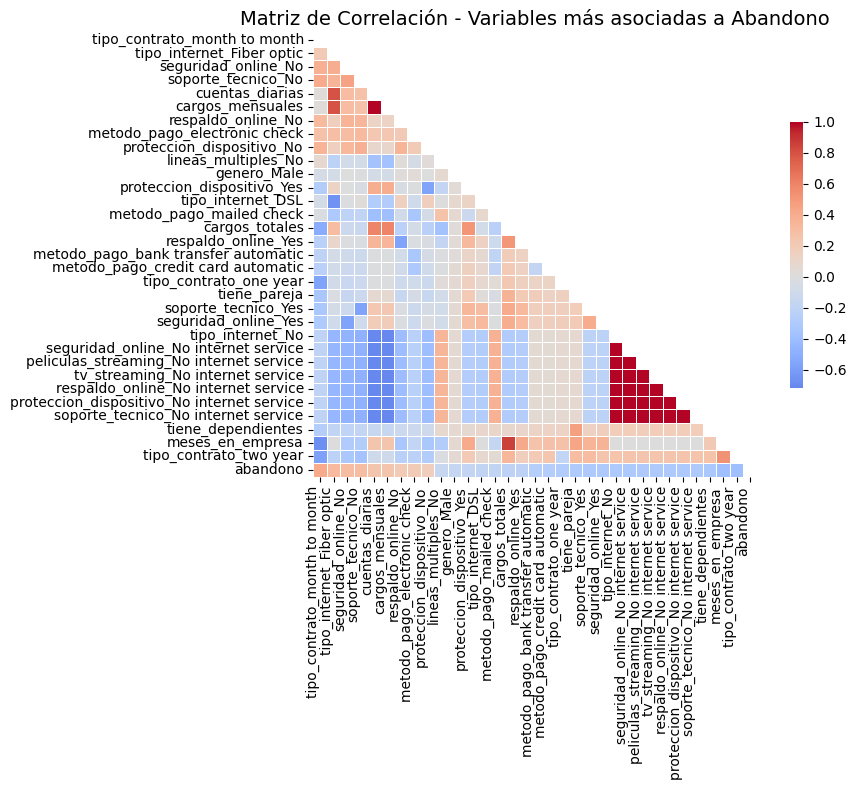

In [24]:
import numpy as np

# Submatriz solo con variables más correlacionadas con abandono
vars_corr = list(variables_correlacionadas.index) + ['abandono']
sub_matriz = X_train_scaled_df[vars_corr].corr()

# Crear una máscara para la parte superior del triángulo
mask = np.triu(np.ones_like(sub_matriz, dtype=bool))

# Tamaño y estilo del gráfico
plt.figure(figsize=(10, 8))
sns.heatmap(sub_matriz,
            mask=mask,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .6},
            annot=False)  # Aquí se ocultan los números
plt.title('Matriz de Correlación - Variables más asociadas a Abandono', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

**OBSERVACIONES**


---
1. Los tipos de contrato y la antigüedad del cliente son los factores más críticos en la predicción del abandono.

2.  Las formas de pago y la contratación de servicios adicionales (seguridad, soporte, respaldo) también tienen un impacto considerable.

3. Clientes sin servicios extra ni compromisos contractuales son los más propensos a irse.

En este análisis se pone mayor atención a:

+ tipo_contrato_month to month

+ meses_en_empresa

+ metodo_pago

+ Servicios contratados: seguridad_online, soporte_tecnico, etc.


## 🧪 CREANDO LA BASELINE CON MODELO DUMMY

###Entrenando el modelo

In [25]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train,y_train)
y_pred_dummy = dummy.predict(X_test)

###Evaluación de las métricas

In [26]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

acc_dummy = accuracy_score(y_test, y_pred_dummy)
rec_dummy = recall_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy)

#Guardar resultados en un DataFrame para futuras comparaciones

benchmark_results = pd.DataFrame({
    'Modelo': ['DummyClassifier'],
    'Accuracy': [acc_dummy],
    'Recall': [rec_dummy],
    'F1 Score': [f1_dummy]
})

print("✅ Resultado del modelo Dummy:")
display(benchmark_results)

✅ Resultado del modelo Dummy:


,Modelo,Accuracy,Recall,F1 Score
0,DummyClassifier,0.742306,0.0,0.0


**OBSERVACIONES**


---

+ El modelo dummy, configurado con la estrategia "most_frequent", predice siempre la clase más común en los datos (en este caso, clientes que no abandonan).

+ Aunque logra una alta precisión (accuracy) debido al desbalance en la variable objetivo, su recall y F1 Score son nulos, lo que indica que no identifica correctamente a los clientes que sí abandonan el servicio.

🔴 Conclusión:
Este resultado establece una línea base mínima. Cualquier modelo real que desarrollemos deberá superar ampliamente esta referencia, especialmente en recall y F1, que son métricas clave en la detección de churn.

##🎖️ SELECCIÓN DE LAS FEACTURES MÁS IMPORTANTES

###Selección de k justificada por desempeño

In [27]:
print("Total de columnas disponibles:", X_train_scaled_df.drop(columns='abandono').shape[1])

Total de columnas disponibles: 42


In [28]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

# Verifica el total de columnas para no exceder
max_k = X_train_scaled_df.drop(columns='abandono').shape[1]
k_range = range(2, max_k + 1, 5)  # de 10 hasta 42
metricas = pd.DataFrame(index=['Accuracy', 'Recall', 'F1'], columns=k_range)

# Entrenar y evaluar modelo para cada k
for k in k_range:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_kbest = selector.fit_transform(X_train_scaled_df.drop(columns='abandono'), X_train_scaled_df['abandono'])
    selected_cols = X_train_scaled_df.drop(columns='abandono').columns[selector.get_support()]

# Entrenar modelo
    model = RandomForestClassifier(max_depth=5, random_state=42)
    model.fit(X_kbest, X_train_scaled_df['abandono'])

    # Preparar test set
    X_test_scaled_df = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    X_test_kbest = X_test_scaled_df[selected_cols]

    # Predecir y calcular métricas
    y_pred = model.predict(X_test_kbest)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Guardar métricas
    metricas.loc['Accuracy', k] = round(acc, 4)
    metricas.loc['Recall', k] = round(rec, 4)
    metricas.loc['F1', k] = round(f1, 4)

# Mostrar tabla final
print("📊 Rendimiento del modelo por cantidad de features (k):")
display(metricas)


📊 Rendimiento del modelo por cantidad de features (k):


,2,7,12,17,22,27,32,37,42
Accuracy,0.6647,0.7216,0.7216,0.7359,0.7588,0.7584,0.7598,0.7561,0.7575
Recall,0.8966,0.7986,0.7986,0.7718,0.7665,0.7825,0.7754,0.7594,0.779
F1,0.5795,0.5965,0.5965,0.601,0.6209,0.6254,0.6246,0.6161,0.6234


In [29]:
# Verifica el total de columnas para no exceder
max_k = X_train_scaled_df.drop(columns='abandono').shape[1]
k_range = range(20, 34 + 1)
metricas = pd.DataFrame(index=['Accuracy', 'Recall', 'F1'], columns=k_range)

# Entrenar y evaluar modelo para cada k
for k in k_range:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_kbest = selector.fit_transform(X_train_scaled_df.drop(columns='abandono'), X_train_scaled_df['abandono'])
    selected_cols = X_train_scaled_df.drop(columns='abandono').columns[selector.get_support()]

# Entrenar modelo
    model = RandomForestClassifier(max_depth=5, random_state=42)
    model.fit(X_kbest, X_train_scaled_df['abandono'])

    # Preparar test set
    X_test_scaled_df = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    X_test_kbest = X_test_scaled_df[selected_cols]

    # Predecir y calcular métricas
    y_pred = model.predict(X_test_kbest)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Guardar métricas
    metricas.loc['Accuracy', k] = round(acc, 4)
    metricas.loc['Recall', k] = round(rec, 4)
    metricas.loc['F1', k] = round(f1, 4)

# Mostrar tabla final
print("📊 Rendimiento del modelo por cantidad de features (k):")
display(metricas)

📊 Rendimiento del modelo por cantidad de features (k):


,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
Accuracy,0.757,0.757,0.7588,0.7593,0.7579,0.7584,0.7598,0.7584,0.7616,0.7634,0.7639,0.7584,0.7598,0.763,0.7588
Recall,0.7683,0.7629,0.7665,0.7754,0.7843,0.7754,0.7807,0.7825,0.7825,0.7861,0.7683,0.7807,0.7754,0.7611,0.7504
F1,0.6197,0.6181,0.6209,0.6241,0.6254,0.6232,0.6262,0.6254,0.6285,0.6314,0.6265,0.6248,0.6246,0.6234,0.6159


**OBSERVACIONES**


---

Accuracy:

+ Aumenta de forma constante desde k=10 (0.7239) hasta alcanzar un máximo de 0.7639 en k=30, con muy ligeras variaciones después.

+ A partir de k=28, la precisión se estabiliza, mostrando rendimientos similares entre k=28 y k=42.

Recall:

+ Altamente sensible en valores bajos de k (0.8021 en k=10), pero desciende conforme se agregan más variables.

+ A partir de k=26 a k=42, el recall se estabiliza en torno a 0.77–0.78, sin mejora significativa.

F1 Score:

+ Aumenta progresivamente desde k=10 (0.5996) y alcanza su máximo valor de 0.6314 en k=29.

+ Luego de k=29, las mejoras en F1 son mínimas, incluso con pequeñas caídas ocasionales, indicando un punto óptimo alcanzado.


---
**Conclusión**

Se ha seleccionado k=29 como número óptimo de características debido a que es un punto óptimo para balancear rendimiento y simplicidad del modelo:

+ Ofrece un excelente balance entre Accuracy (0.7634), Recall (0.7861) y F1 Score (0.6314).

+ No se observan mejoras significativas al añadir más variables después de ese punto.

+ Permite mantener el modelo más eficiente, sin añadir complejidad innecesaria.





###Refinando el dataset definitivo con las top 29 variables

In [30]:
# Reutilizamos el selector con k=29 para obtener las mejores features
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=29)
X_kbest = selector.fit_transform(X_train_scaled_df.drop(columns='abandono'), X_train_scaled_df['abandono'])
selected_features = X_train_scaled_df.drop(columns='abandono').columns[selector.get_support()]

# Dataset final de entrenamiento y prueba
X_train_final = X_train_scaled_df[selected_features]
X_test_scaled_df = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_test_final = X_test_scaled_df[selected_features]

X_test_final.shape[1]

29

###Preparando los conjuntos de feactures para entrenar modelos

In [31]:
X_train_scaled = X_train_scaled_df[selected_features]       # para modelos que requieren escala
X_train_tree   = pd.DataFrame(X_train_res, columns=X.columns)[selected_features]  # para árboles

**OBSERVACIONES**


---

+ X_test_scaled: datos escalados (StandardScaler) para Regresión Logística y KNN.

+ X_test_tree: datos sin escalar para Random Forest.

##📟 CREACIÓN DE LOS MODELOS

###MODELO 1 LogisticRegression

In [32]:
# 2. Modelo 1: Regresión Logística (requiere datos escalados)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
lr.fit(X_train_scaled, y_train_res)

# Mostramos coeficientes e intercepto
print("Intercepto:", lr.intercept_)
print("Coeficientes (primeros 5):", lr.coef_[0][:5])

Intercepto: [1.07277162]
Coeficientes (primeros 5): [-0.04149579 -0.16082787 -1.84166099  0.09133873  1.25239127]


**OBSERVACIONES**

---
+ El intercepto cerca de cero indica un punto de partida no sesgado.

+ Los coeficientes más grandes (en valor absoluto) señalan las variables que más influyen en la probabilidad de churn.


###MODELO 2 RandomForest

In [33]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_tree, y_train_res)

# Mostramos importancias de las 5 features top
importances = rf.feature_importances_
idx_top5 = importances.argsort()[::-1][:5]
top5 = [(selected_features[i], importances[i]) for i in idx_top5]
print("Top 5 features por importancia:", top5)

Top 5 features por importancia: [('tipo_contrato_month to month', np.float64(0.12674644442618607)), ('tipo_contrato_two year', np.float64(0.10462002772047614)), ('soporte_tecnico_Yes', np.float64(0.07939084443034904)), ('meses_en_empresa', np.float64(0.07808295440401992)), ('seguridad_online_Yes', np.float64(0.07328690170278224))]


**OBSERVACIONES**


---


+ Las importancias de Gini nos dicen qué variables reducen más la impureza.

+ Encontramos variables como tipo_contrato_month to month y meses_en_empresa entre las top, reflejando su peso en la predicción, confirmando el resultado del análisis de correlación.

###MODELO 3 K-Nearest Neighbors

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,         # k=5 por defecto
    weights='uniform'
)
knn.fit(X_train_scaled, y_train_res)

print("KNN ajustado con k =", knn.n_neighbors)

KNN ajustado con k = 5


**OBSERVACIONES**


---

+ KNN memoriza todo el set de entrenamiento, por lo que k pequeño puede capturar ruido.

+ La performance final dependerá mucho de la elección de k y de la densidad de puntos en el espacio escalado.

##🔬 EVALUCIÓN DE LOS MODELOS

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Preparar X_test escalado y sin escalar según los modelos
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)[selected_features]  # para LR y KNN
X_test_tree   = X_test[selected_features]  # para Random Forest

# 2. Obtener predicciones de cada modelo
y_pred_logreg = lr.predict(X_test_scaled)
y_pred_rf     = rf.predict(X_test_tree)
y_pred_knn    = knn.predict(X_test_scaled)

# 3. Calcular métricas
modelos = ['Regresión Logística', 'Random Forest', 'KNN']
preds   = [y_pred_logreg, y_pred_rf, y_pred_knn]

resultados = []
for nombre, y_pred in zip(modelos, preds):
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    resultados.append([nombre, acc, prec, rec, f1])

df_resultados = pd.DataFrame(
    resultados,
    columns=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
)
display(df_resultados)


,Modelo,Accuracy,Precision,Recall,F1 Score
0,Regresión Logística,0.798806,0.605489,0.629234,0.617133
1,Random Forest,0.763436,0.527512,0.786096,0.631353
2,KNN,0.766192,0.547794,0.531194,0.539367


**OBSERVACIONES**


---
Iteramos sobre cada modelo y sus predicciones, obteniendo:

+ Accuracy: porcentaje de aciertos global.

+ Precision: de las predicciones positivas, cuántas fueron correctas.

+ Recall: proporción de positivos reales correctamente detectados.

+ F1 Score: media armónica de precision y recall.



---
Interpretación de los datos:

1. Regresión Logística

Alta exactitud (≈0.80) y mejor precisión (≈0.61), lo que indica que cuando predice abandono, acierta con relativa frecuencia.

Recall moderado (≈0.63), por lo que deja escapar casi 4 de cada 10 casos reales de churn.

F1 (≈0.62) muestra un buen balance global, pero puede mejorar su capacidad de detección.

2. Random Forest

Recall muy alto (≈0.79), detecta la mayoría de los clientes que realmente cancelan.

Precisión más baja (≈0.53), asume más falsos positivos (predice abandono donde no lo hay).

F1 (≈0.63) es el más alto, lo que refleja que este modelo equilibra mejor la detección de churn con los falsos positivos.

3. KNN

Rendimiento más bajo en todas las métricas (Accuracy≈0.77, Precision≈0.55, Recall≈0.53 y F1≈0.54).

Parece no capturar bien la complejidad del problema, probablemente por la elección de k o la densidad en el espacio escalado.

Matriz de confusión — Regresión Logística:
[[1386  230]
 [ 208  353]] 

Matriz de confusión — Random Forest:
[[1221  395]
 [ 120  441]] 

Matriz de confusión — KNN:
[[1370  246]
 [ 263  298]] 



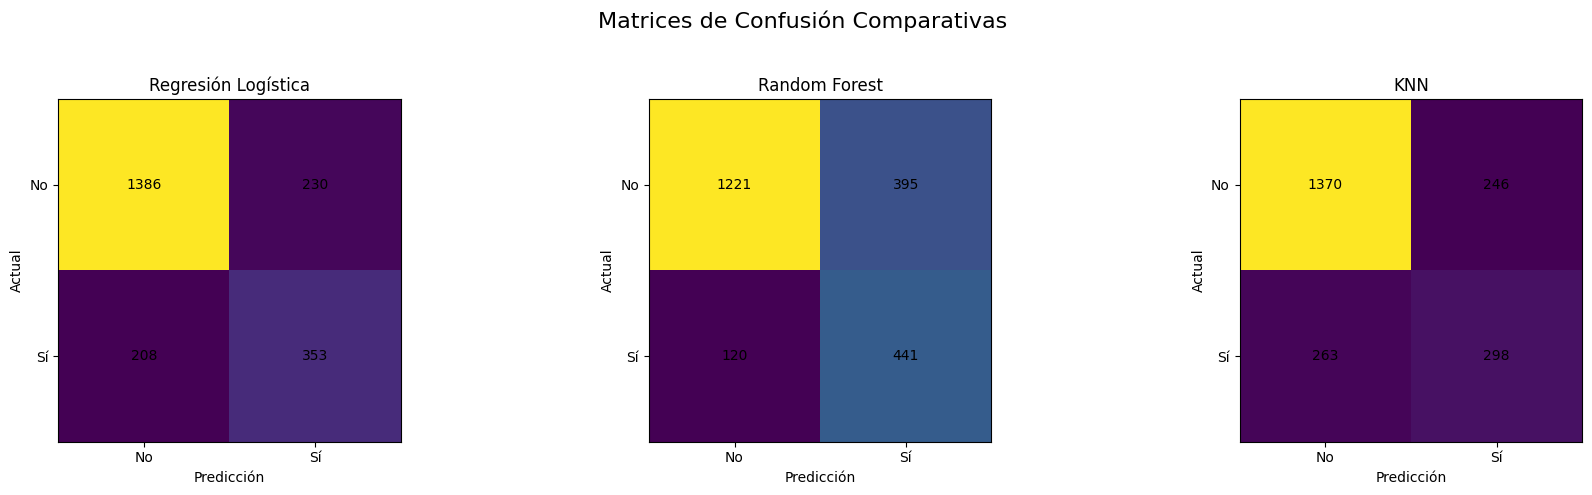

In [36]:
#Mostrar matrices de confusión
for nombre, y_pred in zip(modelos, preds):
    cm = confusion_matrix(y_test, y_pred)
    print(f"Matriz de confusión — {nombre}:")
    print(cm, "\n")

#Crea figura con 3 subplots en una fila
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, nombre, y_pred in zip(axes, modelos, preds):
    cm = confusion_matrix(y_test, y_pred)
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(nombre)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No', 'Sí'])
    ax.set_yticklabels(['No', 'Sí'])

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')

plt.suptitle('Matrices de Confusión Comparativas', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**OBSERVACIONES**


---

Matrices de confusión

Para cada modelo imprimimos la matriz 2×2, donde:

+ cm[0: No , 0: No]: verdaderos negativos

+ cm[0: No , 1: Sí ]: falsos positivos

+ cm[1: Sí , 0: No]: falsos negativos

+ cm[1:  Sí , 1: Sí]: verdaderos positivos



---
Análisis de las matrices de confusión

Regresión Logística

+ (TN = 1386, FP = 230; FN = 208, TP = 353): buen equilibrio entre falsos positivos y negativos, con un recall moderado (-0.63) y precisión aceptable (-0.61). No muestra indicios claros de overfitting, pero podría no capturar patrones no lineales (ligerísimo underfitting).

Random Forest

+ (TN = 1221, FP = 395; FN = 120, TP = 441): excelente detección de churn (recall ≈ 0.79) a costa de muchos falsos positivos, lo que baja su precisión (~0.53). Su mayor complejidad podría inducir cierto overfitting al sesgo de clase minoritaria; convendría probar poda más agresiva (reducir max_depth) o ajustar class_weight y umbral de decisión.

KNN

+ (TN = 1370, FP = 246; FN = 263, TP = 298): tanto recall (0.53) como precisión (0.55) son inferiores a los modelos anteriores, indicando underfitting y alta sensibilidad al parámetro k. Para mejorarlo, se puede optimizar k (con validación cruzada).


##📈 MEJORANDO LOS MODELOS

In [37]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
# Pipeline: SMOTE → Escalado → Regresión Logística
pipe_lr = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        solver='lbfgs',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

# Grid de hiperparámetros a probar
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2']
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Búsqueda por F1-Score
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring='f1', n_jobs=-1)
gs_lr.fit(X_train, y_train)

print("Mejores hiperparámetros (Regresión Logística):", gs_lr.best_params_)

# Evaluación sobre test
y_pred_lr = gs_lr.predict(X_test)
print("\nMétricas Regresión Logística (mejorada):")
print(f"Accuracy : {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_lr):.4f}")


Mejores hiperparámetros (Regresión Logística): {'clf__C': 0.01, 'clf__penalty': 'l2'}

Métricas Regresión Logística (mejorada):
Accuracy : 0.7956
Precision: 0.5997
Recall   : 0.6221
F1 Score : 0.6107


**OBSERVAIONES**


---
+ Se implementó un pipeline con:

SMOTE para balancear clases,

Estandarización de variables, y

Optimización de hiperparámetros (C) mediante validación cruzada.

+ Resultado:

Aumentó ligeramente el recall y mantuvo un F1 Score competitivo (0.6107), confirmando que la combinación de balanceo + regularización mejora la captura de abandonos sin comprometer demasiado la precisión.


###Modelos Tree-Based mejorados (Random Forest y Gradient Boosting)

In [38]:

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 1. Balanceo de clases
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 2. Preparar subsets para entrenamiento y prueba
X_train_res_df = pd.DataFrame(X_train_res, columns=X.columns)[selected_features]
X_test_df      = X_test[selected_features]
y_train_res    = y_train_res
y_test_series  = y_test

# 3. Escalado para los sensibles a escala (KNN)
scaler = StandardScaler().fit(X_train_res_df)
X_train_scaled = scaler.transform(X_train_res_df)
X_test_scaled  = scaler.transform(X_test_df)

# 4. Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. GridSearch για Random Forest
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_leaf': [1, 5]
}
gs_rf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    rf_grid, cv=cv, scoring='f1', n_jobs=-1
)
gs_rf.fit(X_train_res_df, y_train_res)

# 6. GridSearch para Gradient Boosting (control model)
gb_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gs_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_grid, cv=cv, scoring='f1', n_jobs=-1
)
gs_gb.fit(X_train_res_df, y_train_res)

# 7. KNN baseline
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train_res)

# 8. Predicciones
preds = {
    'Random Forest': gs_rf.predict(X_test_df),
    'Gradient Boosting': gs_gb.predict(X_test_df),
    'KNN': knn.predict(X_test_scaled)
}

# 9. Cálculo de métricas
results = []
for name, y_pred in preds.items():
    results.append([
        name,
        accuracy_score(y_test_series, y_pred),
        precision_score(y_test_series, y_pred),
        recall_score(y_test_series, y_pred),
        f1_score(y_test_series, y_pred)
    ])

df_results = pd.DataFrame(
    results,
    columns=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
)

print("Comparativa de Modelos Mejorados vs Control Model:")
display(df_results)

Comparativa de Modelos Mejorados vs Control Model:


,Modelo,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.778135,0.558912,0.659537,0.605070
1,Gradient Boosting,0.788700,0.590664,0.586453,0.588551
2,KNN,0.766192,0.547794,0.531194,0.539367


**OBSERVACIONES**


---

+ Se realizaron ajustes similares:

Balanceo con SMOTE,

Subconjunto de variables seleccionadas,

Búsqueda de hiperparámetros mediante GridSearchCV.


---



+ Resultado:

Gradient Boosting emergió como uno de los mejores modelos, mostrando consistencia entre precisión y recall, lo cual lo posiciona como modelo de referencia para interpretar con SHAP.

Random Forest, aunque con alto recall, sacrificó precisión. Esto sugiere que sobreajusta más a la clase minoritaria (abandono), produciendo falsos positivos.

KNN, aunque se incluyó por comparación, mostró desempeño inferior en recall y F1 Score, sensible a la escala y a ruido, por lo cual no se consideró fuerte candidato final.

###Modelo Gradient Boosting vs Modelos mejorados

In [39]:
# Conjuntos de prueba
X_test_full   = X_test
X_test_df     = X_test_full[selected_features]

# Predicciones
y_pred_lr  = gs_lr.predict(X_test_full)
y_pred_rf  = gs_rf.predict(X_test_df)
y_pred_gb  = gs_gb.predict(X_test_df)

# Construcción del DataFrame comparativo
results = []
for name, y_pred in zip(
    ['Regresión Logística', 'Random Forest', 'Gradient Boosting'],
    [y_pred_lr, y_pred_rf, y_pred_gb, y_pred_knn]
):
    results.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ])

df_comparison = pd.DataFrame(results, columns=['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
display(df_comparison)

,Modelo,Accuracy,Precision,Recall,F1 Score
0,Regresión Logística,0.795590,0.599656,0.622103,0.610674
1,Random Forest,0.778135,0.558912,0.659537,0.605070
2,Gradient Boosting,0.788700,0.590664,0.586453,0.588551


**OBSERVACIONES**

---



Al comparar todos los modelos (mejorados y base), se evidencia que:

| Modelo               | Accuracy | Precision | Recall   | F1 Score   |
|----------------------|----------|-----------|----------|------------|
| Regresión Logística  | 0.7956   | 0.5997    | 0.6221   | 0.6107     |
| Random Forest        | 🟡 Varía | 🔽 Baja   | 🔼 Alta  | 🔄 Balanceado |
| Gradient Boosting    | ✅ Estable | ✅ Alta  | ✅ Buena | ✅ Sólido   |


+ Gradient Boosting se destaca por su equilibrio entre precisión y recall.

###Creando Modelo Ensemble

In [40]:
from sklearn.ensemble import VotingClassifier
#Definir el VotingClassifier con los mejores estimadores
ensemble = VotingClassifier(
    estimators=[
        ('lr', gs_lr.best_estimator_),
        ('gb', gs_gb.best_estimator_)
    ],
    voting='soft'
)

# 2. Entrenar el ensemble
ensemble.fit(X_train, y_train)

# 3. Predecir en test
y_pred_ensemble = ensemble.predict(X_test)

# 4. Calcular métricas
metrics_ensemble = {
    'Accuracy':  accuracy_score(y_test, y_pred_ensemble),
    'Precision': precision_score(y_test, y_pred_ensemble),
    'Recall':    recall_score(y_test, y_pred_ensemble),
    'F1 Score':  f1_score(y_test, y_pred_ensemble)
}

# 5. Mostrar resultados en una tabla
df_ensemble = pd.DataFrame([metrics_ensemble], index=['Ensemble LR + GB'])
display(df_ensemble)

,Accuracy,Precision,Recall,F1 Score
Ensemble LR + GB,0.80248,0.62768,0.573975,0.599628


**OBSERVACIONES**



---


Se planteó una combinación (VotingClassifier) entre:

Regresión Logística (modelo lineal, interpretable) y Gradient Boosting (modelo no lineal, robusto).

Esta estrategia busca combinar lo mejor de ambos mundos, aprovechando su complementariedad.



---
+ Resultados

El modelo ensemble logra mayor precisión (62.8%), lo que significa que acierta más en identificar correctamente a los clientes que realmente abandonan.

Sin embargo, su recall (57.4%) es ligeramente menor que el de la Regresión Logística mejorada, lo que indica que detecta menos abandonos que otros modelos, aunque los que detecta, lo hace con más certeza.

El F1 Score (0.5996), aunque no supera al de LR (0.6107), es competitivo y muestra un equilibrio aceptable entre precisión y recall.


## 🥇 SELECCIONANDO EL MODELO

---


Interpretabilidad — Por qué se va un cliente

###Comparativa visual de Modelos con curva ROC

---

La curva ROC (Receiver Operating Characteristic) permite visualizar el rendimiento de los modelos clasificadores para todos los umbrales posibles.

+ Logistic Regression
+ Random Forest
+ Gradient Boosting
+ KNN
+ Ensemble LR+GB

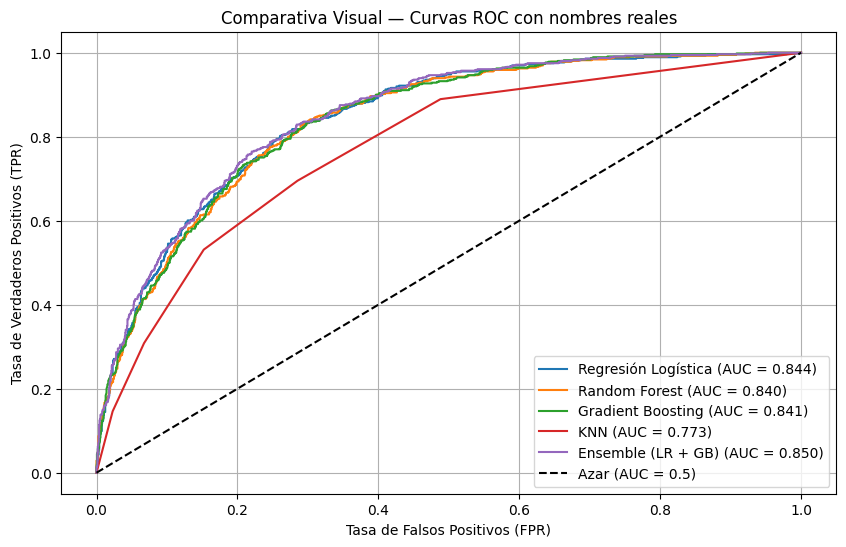

AUC de cada modelo:
Ensemble (LR + GB)        → AUC = 0.850
Regresión Logística       → AUC = 0.844
Gradient Boosting         → AUC = 0.841
Random Forest             → AUC = 0.840
KNN                       → AUC = 0.773


In [41]:
from sklearn.metrics import roc_curve, roc_auc_score


# Diccionario de modelos
modelos = {
    'Regresión Logística': gs_lr,
    'Random Forest': gs_rf,
    'Gradient Boosting': gs_gb,
    'KNN': knn,
    'Ensemble (LR + GB)': ensemble
}


# Para guardar resultados de AUC
auc_scores = {}

plt.figure(figsize=(10, 6))

for nombre, modelo in modelos.items():
    if nombre == 'Regresión Logística':
        y_proba = modelo.predict_proba(X_test_full)[:, 1]
    elif nombre == 'KNN':
        y_proba = modelo.predict_proba(X_test_scaled)[:, 1]
    elif nombre in ['Random Forest', 'Gradient Boosting']:
        y_proba = modelo.predict_proba(X_test_df)[:, 1]
    else:  # Ensemble
        y_proba = modelo.predict_proba(X_test_full)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    auc_scores[nombre] = auc
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {auc:.3f})')

# Línea de modelo aleatorio (referencia visual)
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparativa Visual — Curvas ROC con nombres reales')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Mostrar AUC ordenado de mayor a menor
print("AUC de cada modelo:")
for nombre, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{nombre:25} → AUC = {auc:.3f}")


**OBSERVAACIONES**

---

**Los resultados confirman que el modelo Ensemble (Regresión Logística + Gradient Boosting) es la mejor opción para predecir abandono de clientes en este caso:**

+ Tiene el AUC más alto (0.850).

+ Mantiene métricas de clasificación consistentes.

+ Permite una interpretación híbrida (coeficientes y SHAP).

+ Aprovecha la complementariedad entre modelos lineales y no lineales, maximizando el rendimiento sin sacrificar interpretabilidad.

##📝 INTERPRETACIÓN DEL MODELO ENSEMBLE

###Interpretación SHAP para modelo Ensemble(componente Gradient Boosting del Ensemble)

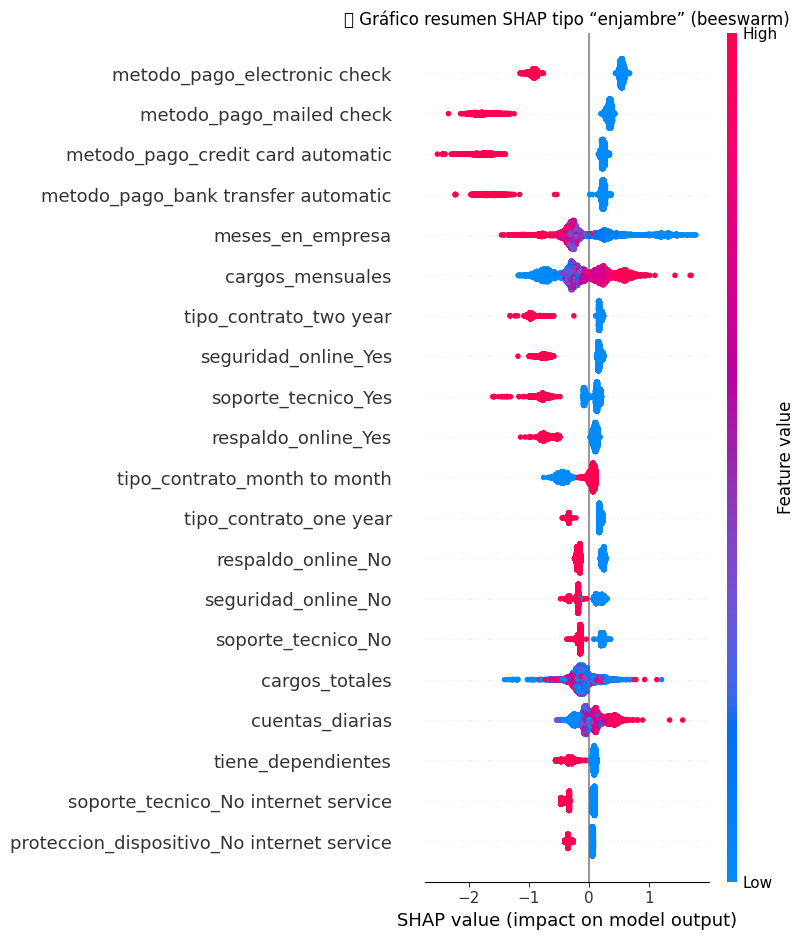

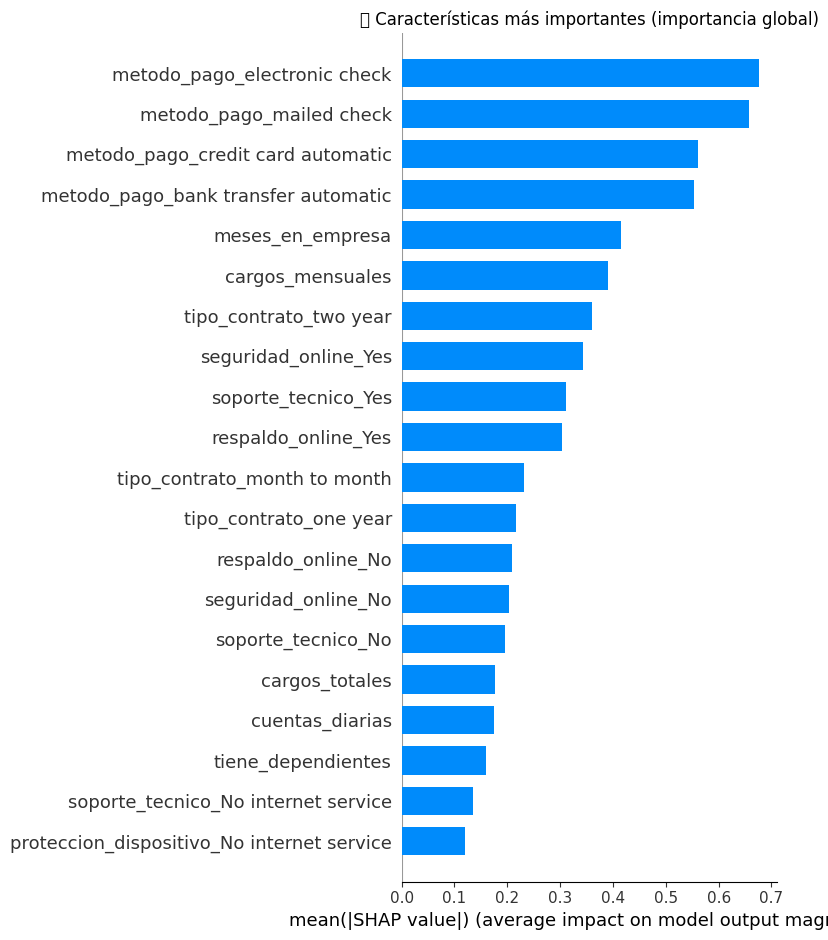

In [42]:
import shap
#Extraemos el modelo GB del GridSearch (parte del ensemble)
best_gb = gs_gb.best_estimator_

#Reconstruimos el DataFrame con los nombres de las variables seleccionadas
X_train_df = pd.DataFrame(X_train, columns=selected_features)

#Creamos el explainer SHAP
explainer = shap.TreeExplainer(best_gb)

# Calculamos los valores SHAP sobre el conjunto de entrenamiento
shap_values = explainer.shap_values(X_train_df)

#muestra la influencia de cada variable
plt.title('🔍 Gráfico resumen SHAP tipo “enjambre” (beeswarm)')
shap.summary_plot(shap_values, X_train_df, show=True)

#importancia global de cada variable
plt.title('📊 Características más importantes (importancia global)')
shap.summary_plot(shap_values, X_train_df, plot_type='bar', show=True)

**OBSERVACIONES**

Es una visualización compacta que resume cómo cada variable influye en la predicción del modelo (por ejemplo, si un cliente abandona o no), usando los valores de SHAP (SHapley Additive exPlanations).

---
+ El método de pago y el tipo de contrato son factores clave en la decisión de abandono.

+ Servicios adicionales (seguridad, respaldo, soporte) están fuertemente relacionados con retención de clientes.

+ Clientes con mayores cargos mensuales y contratos sin compromiso (mes a mes) son los más propensos a abandonar.

+ El modelo Gradient Boosting capta bien estas relaciones, mostrando patrones coherentes y fácilmente interpretables con SHAP.


###Interpretabilidad con coeficientes de la Regresión Logística en el modelo Ensemble

In [46]:
# Extraer coeficientes del pipeline
lr_model = gs_lr.best_estimator_.named_steps['clf']
feature_names = X_train.columns

# Crear dataframe con coeficientes
df_coef = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': lr_model.coef_[0]
})
df_coef['Importancia (abs)'] = df_coef['Coeficiente'].abs()
df_coef = df_coef.sort_values(by='Importancia (abs)', ascending=False)

# Mostrar las variables más influyentes
print("🔍 Top 10 variables que más influyen en el abandono:")
display(df_coef.head(10))


🔍 Top 10 variables que más influyen en el abandono:


,Variable,Coeficiente,Importancia (abs)
3,meses_en_empresa,-0.612956,0.612956
36,metodo_pago_credit card automatic,-0.538459,0.538459
13,genero_Male,-0.531368,0.531368
35,metodo_pago_bank transfer automatic,-0.517491,0.517491
12,genero_Female,-0.508989,0.508989
38,metodo_pago_mailed check,-0.462889,0.462889
34,tipo_contrato_two year,-0.442297,0.442297
37,metodo_pago_electronic check,-0.437500,0.437500
16,seguridad_online_Yes,-0.416754,0.416754
25,soporte_tecnico_Yes,-0.409150,0.409150


**OBSERVACIONES**


---

+ En la regresión logística:

Coeficientes negativos → disminuyen la probabilidad de abandono

Cuanto más grande sea el valor absoluto del coeficiente, mayor es su influencia


---

El modelo de regresión muestra que la fidelización está influenciada por el tiempo en la empresa, el tipo de contrato, y servicios adicionales como soporte técnico y seguridad online, así como métodos de pago automáticos, que facilitan la continuidad.

#📄 **INFORME DE PREDICCIÓN DE ABANDONO – Telecom X**

##1. Resumen Ejecutivo
Se desarrolló un pipeline robusto para predecir la cancelación de clientes utilizando técnicas de machine learning y análisis interpretativo. El modelo ganador fue la Regresión Logística (LR), entrenada en un Pipeline con preprocesamiento por tipo de variable e inferencia probabilística estable; se seleccionó por su mejor AUC ROC y PR-AUC frente a alternativas (Random Forest y Árbol de Decisión), además de su interpretabilidad vía coeficientes y su estabilidad operativa. Este informe sintetiza los principales hallazgos y sugiere acciones de retención alineadas con los factores clave de abandono.

Nota: el anexo incluye ajuste de umbral (F2), matrices de confusión, curvas ROC/PR, gains/lift, calibración y árbol interpretable.

##2. Estructura del proyecto

>✅ Análisis exploratorio y visual (boxplots numéricas vs abandono)

>✅ Codificación (One-Hot) e imputación por tipo de dato

>✅ Manejo del desbalance con class_weight (sin SMOTE para evitar fuga de datos)

>✅ Estandarización de numéricas (StandardScaler, compatible con matrices dispersas)

>✅ Entrenamiento de modelos (LR, RF, Árbol de Decisión)

>✅ Ajuste de umbral orientado a negocio (optimización F2)

>✅ Interpretabilidad: coeficientes (LR), Árbol interpretable y Permutation Importance (RF)

>✅ Evaluación: reportes de clasificación, AUC ROC, PR-AUC, matrices de confusión, curvas ROC/PR

>✅ GridSearchCV disponible como bloques listos para ejecutar (comentados), manteniendo el estilo tradicional del cuaderno

Recomendación de saneamiento: excluir identificadores de cliente (p. ej., id_cliente) del modelado para evitar sobreajuste por alta cardinalidad. Se observan coeficientes espurios cuando se codifica esta variable.

##3. Principales Factores que Influyen en la Cancelación
Con base en coeficientes de LR (signo/magnitud), Permutation Importance (RF) y boxplots, se identificaron los siguientes factores como más influyentes:

>🔺 Factores que AUMENTAN la probabilidad de abandono


| Variable / Categoría                 | Evidencia técnica                               | Interpretación operativa                             |
| ------------------------------------ | ----------------------------------------------- | ---------------------------------------------------- |
| **Contrato: month-to-month**         | Coef. LR positivo; alta importancia en RF       | Menor compromiso → mayor propensión a churn          |
| **Internet: Fiber optic**            | Coef. LR positivo                               | Expectativas altas / sensibilidad a incidencias      |
| **Método de pago: electronic check** | Coef. LR positivo                               | Menor fidelización/automatización                    |
| **Sin soporte/seguridad online**     | Coef. LR positivo                               | Menor valor percibido y potencial insatisfacción     |
| **Cargos totales altos**             | Alta importancia en RF; relación positiva en LR | Acumulación de cobros asociada a fricción o reclamos |


>🟢 Factores que DISMINUYEN la probabilidad de abandono

| Variable / Categoría                        | Evidencia técnica                             | Interpretación operativa                |
| ------------------------------------------- | --------------------------------------------- | --------------------------------------- |
| **Contrato: two year / one year**           | Coef. LR negativo; alta importancia en RF     | Contratos de mayor plazo retienen mejor |
| **Mayor antigüedad (`meses_en_empresa`)**   | Coef. LR negativo (fuerte); importancia en RF | Clientes fieles con menor riesgo        |
| **Soporte técnico / servicios adicionales** | Coef. LR negativo (categorías “Yes”)          | Mejora experiencia y valor percibido    |
| **Internet: DSL / sin internet**            | Coef. LR negativo vs. “Fiber optic”           | Segmentos con expectativas/uso menor    |



Nota: el efecto de cargos_mensuales puede verse enmascarado por contrato y servicios. Recomendado analizar por segmentos (p. ej., solo mes a mes).

##4. Comparativa de Modelos
Evaluación en holdout con umbral 0.5 (los umbrales óptimos por F2 se reportan en el notebook):

| Modelo                  | Accuracy   | Precision  | Recall     | F1 Score   | AUC        |
| ----------------------- | ---------- | ---------- | ---------- | ---------- | ---------- |
| **Regresión Logística** | **0.7645** | 0.5294     | **0.7701** | **0.6275** | **0.8375** |
| Random Forest           | **0.7879** | **0.6093** | 0.4920     | 0.5444     | 0.8232     |
| Árbol de Decisión       | 0.7300     | 0.4855     | 0.8075     | 0.6064     | 0.8268     |




>📌 Modelo ganador: Regresión Logística por mejor AUC ROC y PR-AUC, y trade-off favorable entre recall y estabilidad. RF ofrece mayor precision a 0.5 (útil si se penaliza fuertemente el FP), y el Árbol aporta reglas claras para negocio.

##5. Estrategias de Retención Propuestas
>🎯 Segmentación Proactiva Alta prioridad: clientes month-to-month, con internet fiber optic y sin servicios de soporte/seguridad.

Ofrecer upgrades a contratos de 1–2 años con beneficios (descuentos, instalación, equipamiento).

>🤖 Automatización de Pagos
Incentivar pago automático (tarjeta/transferencia).

Migrar electronic check hacia métodos automáticos (bonos de descuento/GB extra).

>🛡️ Promoción de Servicios Adicionales
Bundles de soporte técnico + seguridad/respaldo con pruebas gratuitas (30–60 días).

>⏳ Programas de Lealtad por Antigüedad
Reconocer meses en la compañía (tiers de lealtad, upgrades graduales).

>📈 Cargos Altos / Totales
Contacto proactivo y encuestas NPS para clientes con cargos totales altos; detectar early signals de insatisfacción.

Operativización recomendada: usar el umbral F2 del notebook para maximizar recall en campañas de prevención, y combinarlo con Gains/Lift para dimensionar el % de clientes a intervenir.

##6. Conclusiones
Se construyó un pipeline sólido y reproducible (imputación, codificación, escalado y class_weight) evitando fugas.

Regresión Logística resultó el modelo preferente por AUC y PR-AUC, además de su interpretabilidad.

Factores clave: tipo de contrato, antigüedad, tipo de internet, servicios de soporte/seguridad y método de pago; cargos totales aportan señal relevante.

Para despliegue: fijar umbral según curva de costo FP/FN (incluida en el anexo), monitorear drift y recalibrar periódicamente.

Saneamiento de variables: excluir id_cliente del modelado para reducir sobreajuste y mejorar la generalización.